In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Binary Logistic Regression

In [2]:
def concat_ones(X):
    # add 1's in front of every training sample (bias)
    return np.concatenate([np.ones(shape=(len(X), 1)), X], axis=1)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_gradient(X_batch, y_batch, weights):
    m = len(y_batch)
    y_preds = sigmoid(np.dot(X_batch, weights))
    errors = y_preds - y_batch
    gradients = (1/m) * np.dot(X_batch.T, errors)
    return gradients

def cross_entropy(y_true, y_pred):
    return -np.mean((y_true * np.log(y_pred)) + ((1-y_true) * np.log(1-y_pred)))

In [3]:
class LogisticRegression:
    def __init__(self, batch_size, lr, iters):
        self.batch_size = batch_size
        self.lr = lr
        self.iters = iters
        self.weights = None
        self.train_loss = []
        self.val_loss = []
    
    def fit(self, X, y, X_val=None, y_val=None):
        X = concat_ones(X)
        if X_val is not None:
            X_val = concat_ones(X_val)

        # random initialization of w^0, shape = (n_features, 1)
        n_features = X.shape[1]
        self.weights = np.random.randn(n_features) # standard Gaussian
        
        for iter in range(self.iters):
            ind = np.random.permutation(len(X)) # shuffle data
            X_shuffled = X[ind]
            y_shuffled = y[ind]

            # mini-batch sgd
            for start in range(0, len(X), self.batch_size):
                end = min(start + self.batch_size, len(X))
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                gradients = compute_gradient(X_batch, y_batch, self.weights)
                self.weights -= self.lr * gradients
            
            # training loss at each iter
            y_pred = sigmoid(np.dot(X, self.weights))
            loss = cross_entropy(y, y_pred)
            self.train_loss.append(loss)

            # validation loss at each iter
            if X_val is not None and y_val is not None:
                y_pred_val = sigmoid(np.dot(X_val, self.weights))
                loss_val = cross_entropy(y_val, y_pred_val)
                self.val_loss.append(loss_val)

                if iter % 500 == 0:
                    print(f"Iteration {iter}: Validation Loss = {loss_val:.4f}")
        
    def logit(self, X):
        X = concat_ones(X)
        return sigmoid(X @ self.weights)
    
    def predict(self, X):
        if self.weights is None:
            raise ValueError("Fit function first using 'fit()")
        logits = self.logit(X)
        return (logits >= 0.5).astype(int)

### (4) Wisconsin Breast Cancer dataset

In [4]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

print("Target:", set(data.target))
print("Target Names:", list(data.target_names))
print("(n_samples, n_features):", data.data.shape)

Target: {0, 1}
Target Names: ['malignant', 'benign']
(n_samples, n_features): (569, 30)


#### 4(b). Split dataset

In [5]:
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

#### 4(c). Class size in each dataset

In [6]:
train_class_sizes = np.bincount(y_train)
val_class_sizes = np.bincount(y_val)
test_class_sizes = np.bincount(y_test)

print(f"Training: {train_class_sizes}")
print(f"Validation: {val_class_sizes}")
print(f"Test: {test_class_sizes}")

Training: [129 212]
Validation: [37 77]
Test: [46 68]


#### 4(d). Train

In [7]:
# feature scaling (zero mean & unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
model = LogisticRegression(batch_size=32, lr=0.001, iters=3000)
model.fit(X_train, y_train, X_val, y_val)

y_pred_val = model.predict(X_val)

# evaluation
val_accuracy = np.mean(y_pred_val == y_val)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

Iteration 0: Validation Loss = 3.1734
Iteration 500: Validation Loss = 0.3004
Iteration 1000: Validation Loss = 0.2089
Iteration 1500: Validation Loss = 0.1686
Iteration 2000: Validation Loss = 0.1441
Iteration 2500: Validation Loss = 0.1270

Validation Accuracy: 0.9561


#### 4(e). Evaluation

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred, target_names=["Malignant", "Benign"])
print(report)

              precision    recall  f1-score   support

   Malignant       0.98      0.91      0.94        46
      Benign       0.94      0.99      0.96        68

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



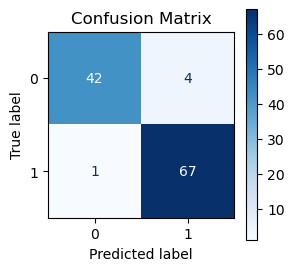

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

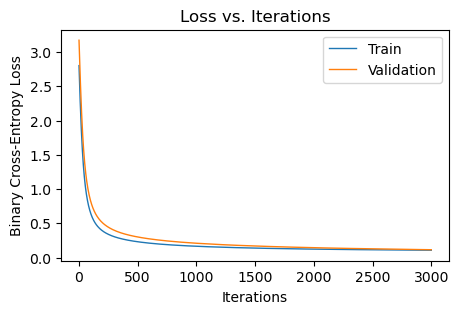

In [12]:
plt.figure(figsize=(5,3))
plt.plot(model.train_loss, label="Train", lw=1)
plt.plot(model.val_loss, label="Validation", lw=1)
plt.title("Loss vs. Iterations")
plt.xlabel("Iterations")
plt.ylabel("Binary Cross-Entropy Loss")
plt.legend()
plt.show()

#### 4(f). Summary


The logistic regression model performs well overall, resulting in **high accuracy (96%)** and reasonable **F1-scores** for both classes. However, further reducing the **recall for malignant class (0.91)** is important as we want to avoid predicint malignant cases as benigh. Further adjustments of class importance and handeling of the slight class imbalances could help improve the model performance.